# 0. Load Data, Library

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!pip install torch torchaudio transformers datasets

In [22]:
!git clone https://github.com/PhamPham2S/NewJeans-5.git

fatal: destination path 'NewJeans-5' already exists and is not an empty directory.


In [23]:
import sys
from pathlib import Path

PROJECT_ROOT = Path("/content/drive/MyDrive/LikeLion/실전 프로젝트 1/Project")
SRC_ROOT = PROJECT_ROOT / "src"
if str(SRC_ROOT) not in sys.path:
    sys.path.insert(0, str(SRC_ROOT))


In [24]:
%cd "/content/drive/MyDrive/LikeLion/실전 프로젝트 1/Project"

/content/drive/.shortcut-targets-by-id/13Uz1efdlntYkSUH521hpq0OZaC1fABeW/실전 프로젝트 1/Project


In [26]:
# reimport
import importlib
importlib.reload(sys.modules['src.core.modeling'])

# src/core 모듈 import
from src.core.data_pipeline import build_embedding_dataloader
from src.core.modeling import FusionModel_train as FusionModel
from src.core.multitask import MultiTaskLoss, MultiTaskLossController
from src.core.grad_monitor import GradientMonitor
from src.core.losses import ordinal_loss

# 기타 PyTorch
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from pathlib import Path

# 1. Hyperparameter setting

In [32]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8
EPOCHS = 2
LEARNING_RATE = 1e-5

# Sample 데이터 경로
data_dir = Path("data/Sample")

# 2. Data Loader

In [ ]:
# Audio Embedding load
from glob import glob
from tqdm import tqdm

# audio_root = Path("/content/drive/MyDrive/LikeLion/실전 프로젝트 1/Project/data/emb/aud_emb/embed-audio-hybrid")
audio_root = Path("/content/NewJeans-5/data/emb/10000_aud_emb")

audio_embeddings = []

for npy_file in tqdm(audio_root.glob("*.npy")):
    emb = np.load(npy_file)
    audio_embeddings.append(
        {
            "emb":emb,
            "id": npy_file.stem
        })

print(f"로드된 audio embedding 개수: {len(audio_embeddings)}")
# print(f"예시 shape: {audio_embeddings[0].shape}")


10000it [00:00, 10457.89it/s]

로드된 audio embedding 개수: 10000


In [ ]:
# Text Embedding load
# txt_root = Path("/content/drive/MyDrive/LikeLion/실전 프로젝트 1/Project/data/emb/txt_emb")
txt_root = Path("/content/NewJeans-5/data/emb/txt_emd_data")
txt_embeddings = []

for folder in txt_root.iterdir():
    if folder.is_dir():
        for npy_file in folder.iterdir():
            if npy_file.is_file() and npy_file.suffix == ".npy":
                # print(npy_file)
                # print(npy_file.stem)
                emb = np.load(npy_file)   # 실제 npy 내부 데이터 로드
                txt_embeddings.append(
                    {
                        "emb":emb,
                        "id": npy_file.stem
                    })

print(f"로드된 txt embedding 개수: {len(txt_embeddings)}")
# print(f"예시 shape: {txt_embeddings[0].shape}")


로드된 txt embedding 개수: 10000


In [ ]:
# Data Concat
text_index = {
    item["id"]: item["emb"]
    for item in txt_embeddings
}

embeddings = {}

for item in audio_embeddings:
    id = item["id"]

    if id not in text_index:
        continue  # or log

    embeddings[id] = {
        "audio": item["emb"],
        "text": text_index[id],
    }

print(f"합쳐진 embedding 총 개수: {len(embeddings)}")

missing_text = [
    item["id"] for item in audio_embeddings
    if item["id"] not in text_index
]

print("text missing:", len(missing_text))
print(missing_text[:5])

합쳐진 embedding 총 개수: 10000
text missing: 0
[]


In [ ]:
!pip install tqdm

In [ ]:
# Labeling
import json
from tqdm import tqdm
json_root = Path("/content/drive/MyDrive/LikeLion/실전 프로젝트 1/Project/data/emb/json_emb")

def find_json_by_id(json_root: Path, id: str) -> Path | None:
    """
    여러 폴더 중에서 {id}.json 파일 경로 반환
    """
    for folder in json_root.iterdir():
        # print(folder)
        if not folder.is_dir():
            continue

        json_path = folder / f"{id}.json"
        if json_path.exists():
            # print(f"JSON 파일 존재 : {json_path}")
            return json_path
    print(f"해당하는 json 파일 없음 : {json_path}")
    return None

for id in tqdm(embeddings.keys()):
    json_path = find_json_by_id(json_root, id)

    if json_path is None:
        continue  # or log warning

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    embeddings[id]["urgency"] = data["urgencyLevel"]
    embeddings[id]["sentiment"] = data["sentiment"]

    # print(f"완료된 id: {id}")

100%|██████████| 10000/10000 [57:45<00:00,  2.89it/s]


In [ ]:
# 최종 임베딩 파일 저장 - total_emb.pkl
import pickle

with open("/content/drive/MyDrive/LikeLion/실전 프로젝트 1/Project/data/emb/total_emb.pkl", "wb") as f:
    pickle.dump(embeddings, f)

In [ ]:
!pip install huggingface-hub
from huggingface_hub import create_repo, upload_file

create_repo(
    repo_id=""
)

In [28]:
import pickle

In [30]:
!ls -lh "/content/drive/MyDrive/LikeLion/실전 프로젝트 1/Project/data/emb/total_emb.pkl"


-rw------- 1 root root 0 Jan 15 01:24 '/content/drive/MyDrive/LikeLion/실전 프로젝트 1/Project/data/emb/total_emb.pkl'


In [33]:
with open("/content/drive/MyDrive/LikeLion/실전 프로젝트 1/Project/data/emb/total_emb.pkl", "rb") as f:
    embeddings = pickle.load(f)

URGENCY_ORDER = dict({"상":0, "중":1, "하":2})
SENTIMENT_ORDER = dict({"당황/난처":0, "불안/걱정":1, "중립":2, "기타부정":3})

train_loader = build_embedding_dataloader(
    audio_embeds=[v["audio"] for v in embeddings.values()],
    text_embeds=[v["text"] for v in embeddings.values()],
    urgencies=[URGENCY_ORDER[v["urgency"]] for v in embeddings.values()],
    sentiments=[SENTIMENT_ORDER[v["sentiment"]] for v in embeddings.values()],
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [34]:
URGENCY_ORDER = dict({"상":0, "중":1, "하":2})
URGENCY_ORDER

{'상': 0, '중': 1, '하': 2}

# 3. Model, Multitask Loss Initialize

In [64]:
# Model
model = FusionModel(
    urgency_levels=3,
    sentiment_levels=4,
    fusion_dim=256,
    dropout=0.2
).to(DEVICE)

# MultiTask Loss
controller = MultiTaskLossController(
    warmup_epochs=1,
    urgency_weight=1.0,
    sentiment_weight=0.3,
    use_uncertainty=False
)

criterion = MultiTaskLoss(
    urgency_loss_fn=ordinal_loss,
    sentiment_loss_fn=nn.CrossEntropyLoss(),
    controller=controller
)

# Audio Encoder freeze
# for param in model.audio_encoder.parameters():
#     param.requires_grad = False

optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
grad_monitor = GradientMonitor(model)
grad_monitor


# 4. Training Loop

In [38]:
import torch
torch.cuda.empty_cache()

In [40]:
# Audio Embedding load
from glob import glob
from tqdm import tqdm

In [69]:
from tqdm import tqdm
import torch

model.to(DEVICE)
model.train()

for epoch in tqdm(range(EPOCHS)):
    for batch_idx, batch in enumerate(train_loader):

        for k in batch:
            batch[k] = batch[k].to(DEVICE)

        optimizer.zero_grad()

        outputs = model(batch)
        outputs = {
            "urgency": outputs["urgency"],
            "sentiment": outputs["sentiment"],
        }

        targets = {
            "urgency": batch["urgency"].view(-1).float(),
            "sentiment": batch["sentiment"].view(-1).long()
        }

        losses = criterion(outputs, targets, epoch)

        grad_stats = grad_monitor.log(
            {
                "urgency": losses["urgency"],
                "sentiment": losses["sentiment"],
            },
            step=batch_idx,
            epoch=epoch,
        )

        losses["total"].backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(grad_stats)

        if batch_idx % 50 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Batch {batch_idx}, Loss: {losses["total"].item():.4f}")


  0%|          | 0/2 [00:00<?, ?it/s]

{'urgency_grad_norm': 2.0175015926361084, 'sentiment_grad_norm': 4.379276275634766, 'grad_cosine_similarity': -0.009672945365309715}
Epoch [1/2], Batch 0, Loss: 0.7277
Epoch [1/2], Batch 50, Loss: 0.6101
{'urgency_grad_norm': 1.6310187578201294, 'sentiment_grad_norm': 3.933422565460205, 'grad_cosine_similarity': 0.030618853867053986}
Epoch [1/2], Batch 100, Loss: 0.6435
Epoch [1/2], Batch 150, Loss: 0.6648
{'urgency_grad_norm': 4.822596549987793, 'sentiment_grad_norm': 5.517270565032959, 'grad_cosine_similarity': 0.03033398650586605}
Epoch [1/2], Batch 200, Loss: 0.6469
Epoch [1/2], Batch 250, Loss: 0.6225
{'urgency_grad_norm': 2.318795680999756, 'sentiment_grad_norm': 4.528298854827881, 'grad_cosine_similarity': 0.0057784803211688995}
Epoch [1/2], Batch 300, Loss: 0.6574
Epoch [1/2], Batch 350, Loss: 0.6617
{'urgency_grad_norm': 1.9069323539733887, 'sentiment_grad_norm': 4.580559253692627, 'grad_cosine_similarity': -0.017545782029628754}
Epoch [1/2], Batch 400, Loss: 0.6664
Epoch [1/2

  0%|          | 0/2 [00:03<?, ?it/s]

{'urgency_grad_norm': 5.0083160400390625, 'sentiment_grad_norm': 6.933239459991455, 'grad_cosine_similarity': -0.07008597254753113}
Epoch [1/2], Batch 900, Loss: 0.5809


KeyboardInterrupt: 

##SingleTask

In [72]:
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Model
model = FusionModel(
    urgency_levels=3,
    sentiment_levels=4,   # 있어도 사용 안 함
    fusion_dim=256,
    dropout=0.2
).to(DEVICE)

# Single-task loss (urgency only)
criterion = ordinal_loss   # ← MultiTaskLoss ❌

optimizer = Adam(
    model.parameters(),
    lr=LEARNING_RATE
)

# (선택) gradient monitor
grad_monitor = GradientMonitor(model)


In [73]:
from tqdm import tqdm
import torch

model.to(DEVICE)
model.train()

for epoch in tqdm(range(EPOCHS)):
    for batch_idx, batch in enumerate(train_loader):

        for k in batch:
            batch[k] = batch[k].to(DEVICE)

        optimizer.zero_grad()

        outputs = model(batch)
        preds = outputs["urgency"]

        targets = batch["urgency"].view(-1).float()

        loss = criterion(preds, targets)

        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print(
                f"Epoch [{epoch+1}/{EPOCHS}] "
                f"Batch {batch_idx} "
                f"Loss: {loss.item():.4f}"
            )


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/2] Batch 0 Loss: 0.6961
Epoch [1/2] Batch 50 Loss: 0.6323
Epoch [1/2] Batch 100 Loss: 0.6244
Epoch [1/2] Batch 150 Loss: 0.7713
Epoch [1/2] Batch 200 Loss: 0.6885
Epoch [1/2] Batch 250 Loss: 0.7002
Epoch [1/2] Batch 300 Loss: 0.6329
Epoch [1/2] Batch 350 Loss: 0.6678
Epoch [1/2] Batch 400 Loss: 0.6143
Epoch [1/2] Batch 450 Loss: 0.6951
Epoch [1/2] Batch 500 Loss: 0.6328
Epoch [1/2] Batch 550 Loss: 0.6411
Epoch [1/2] Batch 600 Loss: 0.6516
Epoch [1/2] Batch 650 Loss: 0.7536
Epoch [1/2] Batch 700 Loss: 0.6659
Epoch [1/2] Batch 750 Loss: 0.6427
Epoch [1/2] Batch 800 Loss: 0.6283
Epoch [1/2] Batch 850 Loss: 0.6599
Epoch [1/2] Batch 900 Loss: 0.6425
Epoch [1/2] Batch 950 Loss: 0.6827
Epoch [1/2] Batch 1000 Loss: 0.6879
Epoch [1/2] Batch 1050 Loss: 0.6544
Epoch [1/2] Batch 1100 Loss: 0.6891
Epoch [1/2] Batch 1150 Loss: 0.7035


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch [1/2] Batch 1200 Loss: 0.6746
Epoch [2/2] Batch 0 Loss: 0.6427
Epoch [2/2] Batch 50 Loss: 0.7391
Epoch [2/2] Batch 100 Loss: 0.6231
Epoch [2/2] Batch 150 Loss: 0.6613
Epoch [2/2] Batch 200 Loss: 0.6767
Epoch [2/2] Batch 250 Loss: 0.7248
Epoch [2/2] Batch 300 Loss: 0.6613
Epoch [2/2] Batch 350 Loss: 0.6116
Epoch [2/2] Batch 400 Loss: 0.6467
Epoch [2/2] Batch 450 Loss: 0.7219
Epoch [2/2] Batch 500 Loss: 0.6714
Epoch [2/2] Batch 550 Loss: 0.6259
Epoch [2/2] Batch 600 Loss: 0.6500
Epoch [2/2] Batch 650 Loss: 0.6367
Epoch [2/2] Batch 700 Loss: 0.6799
Epoch [2/2] Batch 750 Loss: 0.6521
Epoch [2/2] Batch 800 Loss: 0.6129
Epoch [2/2] Batch 850 Loss: 0.7109
Epoch [2/2] Batch 900 Loss: 0.6232
Epoch [2/2] Batch 950 Loss: 0.6316
Epoch [2/2] Batch 1000 Loss: 0.6905
Epoch [2/2] Batch 1050 Loss: 0.7167
Epoch [2/2] Batch 1100 Loss: 0.6412


100%|██████████| 2/2 [00:04<00:00,  2.29s/it]

Epoch [2/2] Batch 1150 Loss: 0.7174
Epoch [2/2] Batch 1200 Loss: 0.7568


##layer_Urgency


In [91]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
import sys
sys.path.append("/content/NewJeans-5/src/core")  # 모델링 파일 있는 폴더
from modeling_layer import FusionModel_train


In [90]:
!ls "/content/drive/MyDrive/실전 프로젝트 1/Project/src/core"


ls: cannot access '/content/drive/MyDrive/실전 프로젝트 1/Project/src/core': No such file or directory


In [95]:
import sys
from pathlib import Path

# 1. 프로젝트 src/core 경로 지정
PROJECT_DIR = Path("/content/NewJeans-5/src/core")

# 2. sys.path에 추가 (중복 추가 방지)
if str(PROJECT_DIR) not in sys.path:
    sys.path.append(str(PROJECT_DIR))

# 3. modeling_layer import
from modeling_layer import FusionModel_train

In [96]:
import torch
from torch.optim import Adam

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = FusionModel_train(
    urgency_levels=3,
    fusion_dim=256,
    dropout=0.3
).to(DEVICE)

# ordinal loss 그대로 사용
criterion = ordinal_loss

optimizer = Adam(
    model.parameters(),
    lr=3e-4,          # 4층이므로 이전보다 살짝 낮춤
    weight_decay=1e-4
)

# (선택) gradient monitor
grad_monitor = GradientMonitor(model)


In [100]:
from tqdm import tqdm
import torch

model.train()

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]")

    for batch_idx, batch in enumerate(pbar):

        for k in batch:
            batch[k] = batch[k].to(DEVICE)

        optimizer.zero_grad()

        outputs = model(batch)
        preds = outputs["urgency"]               # (B, K-1)
        targets = batch["urgency"].view(-1).float()

        loss = criterion(preds, targets)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    # 에폭 평균 loss
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] Average Loss: {avg_loss:.4f}")


Epoch [1/2]: 100%|██████████| 1250/1250 [00:04<00:00, 254.89it/s, loss=0.7516]


Epoch [1/2] Average Loss: 0.6202


Epoch [2/2]: 100%|██████████| 1250/1250 [00:04<00:00, 254.29it/s, loss=0.5801]

Epoch [2/2] Average Loss: 0.6150


In [101]:
from tqdm import tqdm
import torch
from torch.optim import Adam

# 하이퍼파라미터
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 5
LEARNING_RATE = 3e-4
BATCH_SIZE = 32
DROPOUT = 0.3
FUSION_DIM = 256
WEIGHT_DECAY = 1e-5

# 모델 & 옵티마이저
model = FusionModel_train(
    urgency_levels=3,
    fusion_dim=FUSION_DIM,
    dropout=DROPOUT
).to(DEVICE)

optimizer = Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# loss
criterion = ordinal_loss  # urgency 전용

# 학습 루프
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]")

    for batch_idx, batch in enumerate(pbar):
        # GPU 이동
        for k in batch:
            batch[k] = batch[k].to(DEVICE)

        optimizer.zero_grad()

        # forward
        outputs = model(batch)
        preds = outputs["urgency"]               # (B, K-1)
        targets = batch["urgency"].view(-1).float()

        # loss
        loss = criterion(preds, targets)

        # backward
        loss.backward()
        optimizer.step()

        # 진행률
        epoch_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

        if batch_idx % 50 == 0:
            print(
                f"Epoch [{epoch+1}/{EPOCHS}] "
                f"Batch {batch_idx} "
                f"Loss: {loss.item():.4f}"
            )

    # 에폭 평균 loss 출력
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] Average Loss: {avg_loss:.4f}")


Epoch [1/5]:   4%|▍         | 56/1250 [00:00<00:04, 271.37it/s, loss=0.6711]

Epoch [1/5] Batch 0 Loss: 0.7018
Epoch [1/5] Batch 50 Loss: 0.7033


Epoch [1/5]:  11%|█         | 138/1250 [00:00<00:04, 266.20it/s, loss=0.6628]

Epoch [1/5] Batch 100 Loss: 0.6922
Epoch [1/5] Batch 150 Loss: 0.7125


Epoch [1/5]:  20%|█▉        | 246/1250 [00:00<00:03, 258.37it/s, loss=0.6215]

Epoch [1/5] Batch 200 Loss: 0.6650
Epoch [1/5] Batch 250 Loss: 0.6524


Epoch [1/5]:  28%|██▊       | 352/1250 [00:01<00:03, 258.07it/s, loss=0.6228]

Epoch [1/5] Batch 300 Loss: 0.6399
Epoch [1/5] Batch 350 Loss: 0.6689


Epoch [1/5]:  34%|███▍      | 430/1250 [00:01<00:03, 255.28it/s, loss=0.7054]

Epoch [1/5] Batch 400 Loss: 0.6756
Epoch [1/5] Batch 450 Loss: 0.6314


Epoch [1/5]:  43%|████▎     | 535/1250 [00:02<00:02, 258.01it/s, loss=0.6764]

Epoch [1/5] Batch 500 Loss: 0.6588
Epoch [1/5] Batch 550 Loss: 0.7375


Epoch [1/5]:  51%|█████▏    | 643/1250 [00:02<00:02, 257.62it/s, loss=0.6878]

Epoch [1/5] Batch 600 Loss: 0.6033
Epoch [1/5] Batch 650 Loss: 0.6878


Epoch [1/5]:  60%|█████▉    | 747/1250 [00:02<00:01, 252.93it/s, loss=0.6613]

Epoch [1/5] Batch 700 Loss: 0.6295


Epoch [1/5]:  64%|██████▍   | 801/1250 [00:03<00:01, 260.13it/s, loss=0.6734]

Epoch [1/5] Batch 750 Loss: 0.6704
Epoch [1/5] Batch 800 Loss: 0.6574


Epoch [1/5]:  71%|███████   | 883/1250 [00:03<00:01, 266.34it/s, loss=0.6840]

Epoch [1/5] Batch 850 Loss: 0.6303
Epoch [1/5] Batch 900 Loss: 0.8066


Epoch [1/5]:  79%|███████▉  | 991/1250 [00:03<00:00, 262.91it/s, loss=0.6299]

Epoch [1/5] Batch 950 Loss: 0.6264
Epoch [1/5] Batch 1000 Loss: 0.6577


Epoch [1/5]:  88%|████████▊ | 1100/1250 [00:04<00:00, 263.13it/s, loss=0.6398]

Epoch [1/5] Batch 1050 Loss: 0.5584
Epoch [1/5] Batch 1100 Loss: 0.6612


Epoch [1/5]:  94%|█████████▍| 1181/1250 [00:04<00:00, 262.29it/s, loss=0.6337]

Epoch [1/5] Batch 1150 Loss: 0.7009
Epoch [1/5] Batch 1200 Loss: 0.5689


Epoch [1/5]: 100%|██████████| 1250/1250 [00:04<00:00, 260.41it/s, loss=0.6394]


Epoch [1/5] Average Loss: 0.6693


Epoch [2/5]:   2%|▏         | 26/1250 [00:00<00:04, 258.95it/s, loss=0.6482]

Epoch [2/5] Batch 0 Loss: 0.7187


Epoch [2/5]:   4%|▍         | 52/1250 [00:00<00:04, 255.24it/s, loss=0.5664]

Epoch [2/5] Batch 50 Loss: 0.6482


Epoch [2/5]:   6%|▌         | 78/1250 [00:00<00:04, 256.54it/s, loss=0.7268]

Epoch [2/5] Batch 100 Loss: 0.5574


Epoch [2/5]:  10%|█         | 130/1250 [00:00<00:04, 257.84it/s, loss=0.7643]

Epoch [2/5] Batch 150 Loss: 0.6694


Epoch [2/5]:  15%|█▍        | 183/1250 [00:00<00:04, 258.64it/s, loss=0.6265]

Epoch [2/5] Batch 200 Loss: 0.7206


Epoch [2/5]:  19%|█▉        | 236/1250 [00:00<00:03, 259.09it/s, loss=0.7179]

Epoch [2/5] Batch 250 Loss: 0.6496


Epoch [2/5]:  23%|██▎       | 289/1250 [00:01<00:03, 260.14it/s, loss=0.7468]

Epoch [2/5] Batch 300 Loss: 0.4489


Epoch [2/5]:  27%|██▋       | 342/1250 [00:01<00:03, 257.38it/s, loss=0.6557]

Epoch [2/5] Batch 350 Loss: 0.7530


Epoch [2/5]:  32%|███▏      | 394/1250 [00:01<00:03, 255.79it/s, loss=0.6033]

Epoch [2/5] Batch 400 Loss: 0.6033


Epoch [2/5]:  36%|███▌      | 446/1250 [00:01<00:03, 256.15it/s, loss=0.6661]

Epoch [2/5] Batch 450 Loss: 0.6434


Epoch [2/5]:  40%|███▉      | 499/1250 [00:01<00:02, 258.89it/s, loss=0.6708]

Epoch [2/5] Batch 500 Loss: 0.5785


Epoch [2/5]:  44%|████▍     | 552/1250 [00:02<00:02, 257.09it/s, loss=0.6204]

Epoch [2/5] Batch 550 Loss: 0.7550


Epoch [2/5]:  46%|████▋     | 579/1250 [00:02<00:02, 258.39it/s, loss=0.6908]

Epoch [2/5] Batch 600 Loss: 0.6177


Epoch [2/5]:  51%|█████     | 633/1250 [00:02<00:02, 259.86it/s, loss=0.6864]

Epoch [2/5] Batch 650 Loss: 0.6990


Epoch [2/5]:  59%|█████▉    | 737/1250 [00:02<00:02, 253.81it/s, loss=0.8022]

Epoch [2/5] Batch 700 Loss: 0.6449
Epoch [2/5] Batch 750 Loss: 0.6514


Epoch [2/5]:  67%|██████▋   | 843/1250 [00:03<00:01, 258.92it/s, loss=0.5323]

Epoch [2/5] Batch 800 Loss: 0.6314
Epoch [2/5] Batch 850 Loss: 0.5922


Epoch [2/5]:  76%|███████▌  | 950/1250 [00:03<00:01, 261.36it/s, loss=0.6693]

Epoch [2/5] Batch 900 Loss: 0.8748
Epoch [2/5] Batch 950 Loss: 0.6367


Epoch [2/5]:  82%|████████▏ | 1031/1250 [00:04<00:00, 259.24it/s, loss=0.6735]

Epoch [2/5] Batch 1000 Loss: 0.6998
Epoch [2/5] Batch 1050 Loss: 0.6456


Epoch [2/5]:  91%|█████████ | 1137/1250 [00:04<00:00, 257.57it/s, loss=0.7424]

Epoch [2/5] Batch 1100 Loss: 0.6297
Epoch [2/5] Batch 1150 Loss: 0.5769


Epoch [2/5]: 100%|██████████| 1250/1250 [00:04<00:00, 257.34it/s, loss=0.5495]


Epoch [2/5] Batch 1200 Loss: 0.6285
Epoch [2/5] Average Loss: 0.6512


Epoch [3/5]:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.5735]

Epoch [3/5] Batch 0 Loss: 0.6981


Epoch [3/5]:   2%|▏         | 28/1250 [00:00<00:04, 269.99it/s, loss=0.5865]

Epoch [3/5] Batch 50 Loss: 0.6232


Epoch [3/5]:   7%|▋         | 82/1250 [00:00<00:04, 263.57it/s, loss=0.7032]

Epoch [3/5] Batch 100 Loss: 0.4881


Epoch [3/5]:  11%|█         | 136/1250 [00:00<00:04, 263.11it/s, loss=0.6580]

Epoch [3/5] Batch 150 Loss: 0.5996


Epoch [3/5]:  15%|█▌        | 190/1250 [00:00<00:04, 263.41it/s, loss=0.6668]

Epoch [3/5] Batch 200 Loss: 0.7916


Epoch [3/5]:  20%|█▉        | 244/1250 [00:00<00:03, 259.66it/s, loss=0.6317]

Epoch [3/5] Batch 250 Loss: 0.6816


Epoch [3/5]:  24%|██▍       | 298/1250 [00:01<00:03, 262.76it/s, loss=0.5847]

Epoch [3/5] Batch 300 Loss: 0.4853


Epoch [3/5]:  26%|██▌       | 325/1250 [00:01<00:03, 260.01it/s, loss=0.6088]

Epoch [3/5] Batch 350 Loss: 0.6783


Epoch [3/5]:  30%|███       | 378/1250 [00:01<00:03, 257.52it/s, loss=0.6521]

Epoch [3/5] Batch 400 Loss: 0.6663


Epoch [3/5]:  34%|███▍      | 431/1250 [00:01<00:03, 256.61it/s, loss=0.6297]

Epoch [3/5] Batch 450 Loss: 0.5831


Epoch [3/5]:  39%|███▊      | 483/1250 [00:01<00:03, 254.15it/s, loss=0.7091]

Epoch [3/5] Batch 500 Loss: 0.5041


Epoch [3/5]:  43%|████▎     | 537/1250 [00:02<00:02, 259.95it/s, loss=0.5944]

Epoch [3/5] Batch 550 Loss: 0.7671


Epoch [3/5]:  47%|████▋     | 591/1250 [00:02<00:02, 259.67it/s, loss=0.6754]

Epoch [3/5] Batch 600 Loss: 0.7623


Epoch [3/5]:  52%|█████▏    | 645/1250 [00:02<00:02, 261.43it/s, loss=0.6170]

Epoch [3/5] Batch 650 Loss: 0.5522


Epoch [3/5]:  56%|█████▌    | 699/1250 [00:02<00:02, 261.07it/s, loss=0.6087]

Epoch [3/5] Batch 700 Loss: 0.7875


Epoch [3/5]:  58%|█████▊    | 726/1250 [00:02<00:02, 258.89it/s, loss=0.5561]

Epoch [3/5] Batch 750 Loss: 0.6406


Epoch [3/5]:  62%|██████▏   | 780/1250 [00:03<00:01, 260.49it/s, loss=0.6548]

Epoch [3/5] Batch 800 Loss: 0.6513


Epoch [3/5]:  67%|██████▋   | 833/1250 [00:03<00:01, 257.03it/s, loss=0.7603]

Epoch [3/5] Batch 850 Loss: 0.5894


Epoch [3/5]:  75%|███████▍  | 936/1250 [00:03<00:01, 250.86it/s, loss=0.7050]

Epoch [3/5] Batch 900 Loss: 0.5761
Epoch [3/5] Batch 950 Loss: 0.7050


Epoch [3/5]:  83%|████████▎ | 1040/1250 [00:04<00:00, 248.01it/s, loss=0.5413]

Epoch [3/5] Batch 1000 Loss: 0.6499


Epoch [3/5]:  87%|████████▋ | 1090/1250 [00:04<00:00, 242.37it/s, loss=0.6951]

Epoch [3/5] Batch 1050 Loss: 0.5951


Epoch [3/5]:  91%|█████████ | 1140/1250 [00:04<00:00, 245.00it/s, loss=0.6225]

Epoch [3/5] Batch 1100 Loss: 0.6841


Epoch [3/5]:  95%|█████████▌| 1192/1250 [00:04<00:00, 249.89it/s, loss=0.6926]

Epoch [3/5] Batch 1150 Loss: 0.6225
Epoch [3/5] Batch 1200 Loss: 0.5929


Epoch [3/5]: 100%|██████████| 1250/1250 [00:04<00:00, 255.75it/s, loss=0.5842]


Epoch [3/5] Average Loss: 0.6409


Epoch [4/5]:   2%|▏         | 26/1250 [00:00<00:04, 258.38it/s, loss=0.5096]

Epoch [4/5] Batch 0 Loss: 0.7675


Epoch [4/5]:   2%|▏         | 26/1250 [00:00<00:04, 258.38it/s, loss=0.6134]

Epoch [4/5] Batch 50 Loss: 0.6134


Epoch [4/5]:  10%|█         | 128/1250 [00:00<00:04, 244.61it/s, loss=0.6765]

Epoch [4/5] Batch 100 Loss: 0.6367


Epoch [4/5]:  14%|█▍        | 179/1250 [00:00<00:04, 246.58it/s, loss=0.5252]

Epoch [4/5] Batch 150 Loss: 0.5529


Epoch [4/5]:  18%|█▊        | 231/1250 [00:01<00:04, 251.85it/s, loss=0.6649]

Epoch [4/5] Batch 200 Loss: 0.6700
Epoch [4/5] Batch 250 Loss: 0.6198


Epoch [4/5]:  27%|██▋       | 336/1250 [00:01<00:03, 250.40it/s, loss=0.5708]

Epoch [4/5] Batch 300 Loss: 0.6570
Epoch [4/5] Batch 350 Loss: 0.5708


Epoch [4/5]:  35%|███▌      | 443/1250 [00:01<00:03, 260.26it/s, loss=0.8871]

Epoch [4/5] Batch 400 Loss: 0.8252
Epoch [4/5] Batch 450 Loss: 0.6934


Epoch [4/5]:  44%|████▍     | 550/1250 [00:02<00:02, 262.23it/s, loss=0.4924]

Epoch [4/5] Batch 500 Loss: 0.6256
Epoch [4/5] Batch 550 Loss: 0.6716


Epoch [4/5]:  50%|█████     | 630/1250 [00:02<00:02, 259.57it/s, loss=0.7333]

Epoch [4/5] Batch 600 Loss: 0.6997
Epoch [4/5] Batch 650 Loss: 0.6947


Epoch [4/5]:  59%|█████▉    | 739/1250 [00:02<00:01, 264.65it/s, loss=0.6520]

Epoch [4/5] Batch 700 Loss: 0.5662
Epoch [4/5] Batch 750 Loss: 0.7111


Epoch [4/5]:  68%|██████▊   | 847/1250 [00:03<00:01, 261.35it/s, loss=0.7287]

Epoch [4/5] Batch 800 Loss: 0.6067
Epoch [4/5] Batch 850 Loss: 0.4813


Epoch [4/5]:  74%|███████▍  | 928/1250 [00:03<00:01, 259.41it/s, loss=0.6672]

Epoch [4/5] Batch 900 Loss: 0.6503
Epoch [4/5] Batch 950 Loss: 0.6837


Epoch [4/5]:  83%|████████▎ | 1036/1250 [00:04<00:00, 261.38it/s, loss=0.5922]

Epoch [4/5] Batch 1000 Loss: 0.6902
Epoch [4/5] Batch 1050 Loss: 0.7049


Epoch [4/5]:  91%|█████████▏| 1141/1250 [00:04<00:00, 256.57it/s, loss=0.5589]

Epoch [4/5] Batch 1100 Loss: 0.5399
Epoch [4/5] Batch 1150 Loss: 0.8206


Epoch [4/5]: 100%|██████████| 1250/1250 [00:04<00:00, 257.24it/s, loss=0.8713]


Epoch [4/5] Batch 1200 Loss: 0.6217
Epoch [4/5] Average Loss: 0.6337


Epoch [5/5]:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.8820]

Epoch [5/5] Batch 0 Loss: 0.6576


Epoch [5/5]:   4%|▍         | 54/1250 [00:00<00:04, 266.71it/s, loss=0.4831]

Epoch [5/5] Batch 50 Loss: 0.5434


Epoch [5/5]:   6%|▋         | 81/1250 [00:00<00:04, 258.13it/s, loss=0.6686]

Epoch [5/5] Batch 100 Loss: 0.5529


Epoch [5/5]:  11%|█         | 135/1250 [00:00<00:04, 257.52it/s, loss=0.7664]

Epoch [5/5] Batch 150 Loss: 0.6539


Epoch [5/5]:  15%|█▌        | 190/1250 [00:00<00:04, 259.91it/s, loss=0.6048]

Epoch [5/5] Batch 200 Loss: 0.7178


Epoch [5/5]:  20%|█▉        | 245/1250 [00:00<00:03, 261.77it/s, loss=0.7793]

Epoch [5/5] Batch 250 Loss: 0.5729


Epoch [5/5]:  24%|██▍       | 299/1250 [00:01<00:03, 263.02it/s, loss=0.4799]

Epoch [5/5] Batch 300 Loss: 0.6249


Epoch [5/5]:  28%|██▊       | 353/1250 [00:01<00:03, 262.60it/s, loss=0.4516]

Epoch [5/5] Batch 350 Loss: 0.6648


Epoch [5/5]:  30%|███       | 380/1250 [00:01<00:03, 261.69it/s, loss=1.0768]

Epoch [5/5] Batch 400 Loss: 0.5057


Epoch [5/5]:  35%|███▍      | 434/1250 [00:01<00:03, 262.50it/s, loss=0.5615]

Epoch [5/5] Batch 450 Loss: 0.6933


Epoch [5/5]:  39%|███▉      | 488/1250 [00:01<00:02, 260.45it/s, loss=0.7150]

Epoch [5/5] Batch 500 Loss: 0.5005


Epoch [5/5]:  43%|████▎     | 542/1250 [00:02<00:02, 260.22it/s, loss=0.6868]

Epoch [5/5] Batch 550 Loss: 0.6119


Epoch [5/5]:  48%|████▊     | 596/1250 [00:02<00:02, 260.02it/s, loss=0.6801]

Epoch [5/5] Batch 600 Loss: 0.7391


Epoch [5/5]:  52%|█████▏    | 650/1250 [00:02<00:02, 260.79it/s, loss=0.5806]

Epoch [5/5] Batch 650 Loss: 0.8584


Epoch [5/5]:  54%|█████▍    | 677/1250 [00:02<00:02, 259.48it/s, loss=0.5486]

Epoch [5/5] Batch 700 Loss: 0.7985


Epoch [5/5]:  58%|█████▊    | 729/1250 [00:02<00:02, 258.66it/s, loss=0.6641]

Epoch [5/5] Batch 750 Loss: 0.8055


Epoch [5/5]:  63%|██████▎   | 783/1250 [00:03<00:01, 259.72it/s, loss=0.5158]

Epoch [5/5] Batch 800 Loss: 0.6651


Epoch [5/5]:  67%|██████▋   | 836/1250 [00:03<00:01, 260.62it/s, loss=0.7323]

Epoch [5/5] Batch 850 Loss: 0.7120


Epoch [5/5]:  71%|███████   | 889/1250 [00:03<00:01, 258.16it/s, loss=0.7411]

Epoch [5/5] Batch 900 Loss: 0.6571


Epoch [5/5]:  75%|███████▌  | 941/1250 [00:03<00:01, 257.62it/s, loss=0.6030]

Epoch [5/5] Batch 950 Loss: 0.5456


Epoch [5/5]:  80%|███████▉  | 995/1250 [00:03<00:00, 259.98it/s, loss=0.7029]

Epoch [5/5] Batch 1000 Loss: 0.5848


Epoch [5/5]:  84%|████████▍ | 1049/1250 [00:04<00:00, 260.04it/s, loss=0.9311]

Epoch [5/5] Batch 1050 Loss: 0.5026


Epoch [5/5]:  88%|████████▊ | 1102/1250 [00:04<00:00, 257.27it/s, loss=0.4766]

Epoch [5/5] Batch 1100 Loss: 0.5035


Epoch [5/5]:  90%|█████████ | 1128/1250 [00:04<00:00, 257.84it/s, loss=0.5785]

Epoch [5/5] Batch 1150 Loss: 0.6222


Epoch [5/5]:  94%|█████████▍| 1180/1250 [00:04<00:00, 254.36it/s, loss=0.7316]

Epoch [5/5] Batch 1200 Loss: 0.6696


Epoch [5/5]: 100%|██████████| 1250/1250 [00:04<00:00, 259.95it/s, loss=0.7320]

Epoch [5/5] Average Loss: 0.6257


In [102]:
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.optim import Adam

# 하이퍼파라미터
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 5
LEARNING_RATE = 3e-4
BATCH_SIZE = 32
WEIGHT_DECAY = 1e-5

# 튜닝용 Fusion Layer + Head 설정
FUSION_DIM = 512          # Fusion 차원 증가 → 표현력 강화
DROPOUT = 0.4             # Dropout 증가 → 과적합 완화
HEAD_HIDDEN = [256, 128]  # Head 내부 레이어 노드 수

# 모델 정의
class FusionModel_train_tuned(nn.Module):
    def __init__(self, urgency_levels: int, fusion_dim: int, dropout: float, head_hidden: list):
        super().__init__()

        # embedding dims (고정)
        audio_dim = 781
        text_dim = 768
        input_dim = audio_dim + text_dim

        # Fusion
        self.fusion = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Linear(input_dim, fusion_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # Head (tunable hidden layers)
        layers = []
        prev_dim = fusion_dim
        for h in head_hidden:
            layers.extend([nn.Linear(prev_dim, h), nn.ReLU(), nn.Dropout(dropout)])
            prev_dim = h
        layers.append(nn.Linear(prev_dim, urgency_levels - 1))  # ordinal
        self.urgency_head = nn.Sequential(*layers)

    def forward(self, batch):
        audio_embed = batch["audio_embed"]
        text_embed = batch["text_embed"]

        fused = self.fusion(torch.cat([audio_embed, text_embed], dim=-1))
        return {"urgency": self.urgency_head(fused)}

# 모델 초기화
model = FusionModel_train_tuned(
    urgency_levels=3,
    fusion_dim=FUSION_DIM,
    dropout=DROPOUT,
    head_hidden=HEAD_HIDDEN
).to(DEVICE)

# 옵티마이저
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# loss
criterion = ordinal_loss

# 학습 루프
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]")

    for batch_idx, batch in enumerate(pbar):
        # GPU 이동
        for k in batch:
            batch[k] = batch[k].to(DEVICE)

        optimizer.zero_grad()

        # forward
        outputs = model(batch)
        preds = outputs["urgency"]
        targets = batch["urgency"].view(-1).float()

        # loss
        loss = criterion(preds, targets)

        # backward
        loss.backward()
        optimizer.step()

        # 진행률
        epoch_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

        if batch_idx % 50 == 0:
            print(
                f"Epoch [{epoch+1}/{EPOCHS}] "
                f"Batch {batch_idx} "
                f"Loss: {loss.item():.4f}"
            )

    # 평균 loss 출력
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] Average Loss: {avg_loss:.4f}")


Epoch [1/5]:   4%|▍         | 48/1250 [00:00<00:04, 240.81it/s, loss=0.6384]

Epoch [1/5] Batch 0 Loss: 0.7145
Epoch [1/5] Batch 50 Loss: 0.7207


Epoch [1/5]:  10%|█         | 131/1250 [00:00<00:04, 264.30it/s, loss=0.6168]

Epoch [1/5] Batch 100 Loss: 0.6708
Epoch [1/5] Batch 150 Loss: 0.6316


Epoch [1/5]:  19%|█▉        | 240/1250 [00:00<00:03, 263.92it/s, loss=0.6057]

Epoch [1/5] Batch 200 Loss: 0.6756
Epoch [1/5] Batch 250 Loss: 0.7085


Epoch [1/5]:  28%|██▊       | 349/1250 [00:01<00:03, 266.36it/s, loss=0.7368]

Epoch [1/5] Batch 300 Loss: 0.6715
Epoch [1/5] Batch 350 Loss: 0.6388


Epoch [1/5]:  34%|███▍      | 431/1250 [00:01<00:03, 264.67it/s, loss=0.6788]

Epoch [1/5] Batch 400 Loss: 0.6340
Epoch [1/5] Batch 450 Loss: 0.7409


Epoch [1/5]:  43%|████▎     | 539/1250 [00:02<00:02, 261.08it/s, loss=0.6832]

Epoch [1/5] Batch 500 Loss: 0.7195
Epoch [1/5] Batch 550 Loss: 0.6759


Epoch [1/5]:  52%|█████▏    | 650/1250 [00:02<00:02, 270.26it/s, loss=0.6367]

Epoch [1/5] Batch 600 Loss: 0.8418
Epoch [1/5] Batch 650 Loss: 0.6505


Epoch [1/5]:  59%|█████▊    | 733/1250 [00:02<00:01, 269.37it/s, loss=0.6217]

Epoch [1/5] Batch 700 Loss: 0.6490
Epoch [1/5] Batch 750 Loss: 0.6893


Epoch [1/5]:  68%|██████▊   | 846/1250 [00:03<00:01, 275.66it/s, loss=0.6614]

Epoch [1/5] Batch 800 Loss: 0.6529
Epoch [1/5] Batch 850 Loss: 0.6130


Epoch [1/5]:  74%|███████▍  | 930/1250 [00:03<00:01, 273.52it/s, loss=0.6847]

Epoch [1/5] Batch 900 Loss: 0.6403
Epoch [1/5] Batch 950 Loss: 0.6592


Epoch [1/5]:  83%|████████▎ | 1042/1250 [00:03<00:00, 268.68it/s, loss=0.5969]

Epoch [1/5] Batch 1000 Loss: 0.6983
Epoch [1/5] Batch 1050 Loss: 0.6723


Epoch [1/5]:  92%|█████████▏| 1153/1250 [00:04<00:00, 269.52it/s, loss=0.6779]

Epoch [1/5] Batch 1100 Loss: 0.5787
Epoch [1/5] Batch 1150 Loss: 0.7504


Epoch [1/5]: 100%|██████████| 1250/1250 [00:04<00:00, 265.70it/s, loss=0.5628]


Epoch [1/5] Batch 1200 Loss: 0.6977
Epoch [1/5] Average Loss: 0.6711


Epoch [2/5]:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.6649]

Epoch [2/5] Batch 0 Loss: 0.6809


Epoch [2/5]:   2%|▏         | 28/1250 [00:00<00:04, 275.75it/s, loss=0.5762]

Epoch [2/5] Batch 50 Loss: 0.6471


Epoch [2/5]:   7%|▋         | 84/1250 [00:00<00:04, 267.41it/s, loss=0.6965]

Epoch [2/5] Batch 100 Loss: 0.6483


Epoch [2/5]:  11%|█         | 138/1250 [00:00<00:04, 268.05it/s, loss=0.6148]

Epoch [2/5] Batch 150 Loss: 0.6221


Epoch [2/5]:  15%|█▌        | 193/1250 [00:00<00:03, 265.52it/s, loss=0.6503]

Epoch [2/5] Batch 200 Loss: 0.6304


Epoch [2/5]:  20%|█▉        | 248/1250 [00:00<00:03, 266.50it/s, loss=0.6558]

Epoch [2/5] Batch 250 Loss: 0.7125


Epoch [2/5]:  24%|██▍       | 302/1250 [00:01<00:03, 263.68it/s, loss=0.6464]

Epoch [2/5] Batch 300 Loss: 0.6732


Epoch [2/5]:  26%|██▋       | 329/1250 [00:01<00:03, 259.73it/s, loss=0.6424]

Epoch [2/5] Batch 350 Loss: 0.6424


Epoch [2/5]:  30%|███       | 381/1250 [00:01<00:03, 257.07it/s, loss=0.6985]

Epoch [2/5] Batch 400 Loss: 0.7025


Epoch [2/5]:  35%|███▍      | 435/1250 [00:01<00:03, 260.53it/s, loss=0.6281]

Epoch [2/5] Batch 450 Loss: 0.6238


Epoch [2/5]:  39%|███▉      | 490/1250 [00:01<00:02, 264.24it/s, loss=0.6828]

Epoch [2/5] Batch 500 Loss: 0.6256


Epoch [2/5]:  44%|████▎     | 544/1250 [00:02<00:02, 262.09it/s, loss=0.5969]

Epoch [2/5] Batch 550 Loss: 0.7474


Epoch [2/5]:  48%|████▊     | 598/1250 [00:02<00:02, 259.96it/s, loss=0.6385]

Epoch [2/5] Batch 600 Loss: 0.6665


Epoch [2/5]:  52%|█████▏    | 652/1250 [00:02<00:02, 259.69it/s, loss=0.7032]

Epoch [2/5] Batch 650 Loss: 0.5859


Epoch [2/5]:  54%|█████▍    | 679/1250 [00:02<00:02, 261.49it/s, loss=0.5639]

Epoch [2/5] Batch 700 Loss: 0.5804


Epoch [2/5]:  59%|█████▊    | 733/1250 [00:02<00:01, 262.62it/s, loss=0.5266]

Epoch [2/5] Batch 750 Loss: 0.7539


Epoch [2/5]:  63%|██████▎   | 787/1250 [00:03<00:01, 263.89it/s, loss=0.6579]

Epoch [2/5] Batch 800 Loss: 0.7257


Epoch [2/5]:  67%|██████▋   | 841/1250 [00:03<00:01, 261.19it/s, loss=0.6012]

Epoch [2/5] Batch 850 Loss: 0.6224


Epoch [2/5]:  72%|███████▏  | 895/1250 [00:03<00:01, 263.80it/s, loss=0.7208]

Epoch [2/5] Batch 900 Loss: 0.6114


Epoch [2/5]:  76%|███████▌  | 951/1250 [00:03<00:01, 268.07it/s, loss=0.5327]

Epoch [2/5] Batch 950 Loss: 0.5763


Epoch [2/5]:  78%|███████▊  | 978/1250 [00:03<00:01, 267.76it/s, loss=0.6477]

Epoch [2/5] Batch 1000 Loss: 0.7103


Epoch [2/5]:  83%|████████▎ | 1034/1250 [00:03<00:00, 269.65it/s, loss=0.6944]

Epoch [2/5] Batch 1050 Loss: 0.5205


Epoch [2/5]:  87%|████████▋ | 1088/1250 [00:04<00:00, 268.79it/s, loss=0.6839]

Epoch [2/5] Batch 1100 Loss: 0.7160


Epoch [2/5]:  91%|█████████▏| 1143/1250 [00:04<00:00, 267.18it/s, loss=0.7137]

Epoch [2/5] Batch 1150 Loss: 0.5475


Epoch [2/5]:  96%|█████████▌| 1198/1250 [00:04<00:00, 268.99it/s, loss=0.7886]

Epoch [2/5] Batch 1200 Loss: 0.6495


Epoch [2/5]: 100%|██████████| 1250/1250 [00:04<00:00, 264.36it/s, loss=0.7334]


Epoch [2/5] Average Loss: 0.6581


Epoch [3/5]:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.6008]

Epoch [3/5] Batch 0 Loss: 0.6411


Epoch [3/5]:   2%|▏         | 29/1250 [00:00<00:04, 280.98it/s, loss=0.5152]

Epoch [3/5] Batch 50 Loss: 0.6997


Epoch [3/5]:   7%|▋         | 86/1250 [00:00<00:04, 272.77it/s, loss=0.7650]

Epoch [3/5] Batch 100 Loss: 0.4740


Epoch [3/5]:  11%|█▏        | 142/1250 [00:00<00:04, 269.19it/s, loss=0.6689]

Epoch [3/5] Batch 150 Loss: 0.6258


Epoch [3/5]:  16%|█▌        | 196/1250 [00:00<00:03, 268.92it/s, loss=0.5707]

Epoch [3/5] Batch 200 Loss: 0.6824


Epoch [3/5]:  20%|██        | 250/1250 [00:00<00:03, 267.39it/s, loss=0.6638]

Epoch [3/5] Batch 250 Loss: 0.6067


Epoch [3/5]:  22%|██▏       | 277/1250 [00:01<00:03, 264.99it/s, loss=0.5607]

Epoch [3/5] Batch 300 Loss: 0.5843


Epoch [3/5]:  27%|██▋       | 332/1250 [00:01<00:03, 266.81it/s, loss=0.7255]

Epoch [3/5] Batch 350 Loss: 0.5291


Epoch [3/5]:  31%|███       | 386/1250 [00:01<00:03, 263.67it/s, loss=0.6901]

Epoch [3/5] Batch 400 Loss: 0.6216


Epoch [3/5]:  35%|███▌      | 440/1250 [00:01<00:03, 263.09it/s, loss=0.4864]

Epoch [3/5] Batch 450 Loss: 0.7820


Epoch [3/5]:  40%|███▉      | 494/1250 [00:01<00:02, 265.73it/s, loss=0.9030]

Epoch [3/5] Batch 500 Loss: 0.6240


Epoch [3/5]:  44%|████▍     | 549/1250 [00:02<00:02, 265.59it/s, loss=0.6696]

Epoch [3/5] Batch 550 Loss: 0.7882


Epoch [3/5]:  48%|████▊     | 603/1250 [00:02<00:02, 265.40it/s, loss=0.7109]

Epoch [3/5] Batch 600 Loss: 0.7052


Epoch [3/5]:  50%|█████     | 630/1250 [00:02<00:02, 264.07it/s, loss=0.6794]

Epoch [3/5] Batch 650 Loss: 0.6615


Epoch [3/5]:  55%|█████▍    | 684/1250 [00:02<00:02, 262.74it/s, loss=0.6226]

Epoch [3/5] Batch 700 Loss: 0.7439


Epoch [3/5]:  59%|█████▉    | 738/1250 [00:02<00:01, 261.54it/s, loss=0.6724]

Epoch [3/5] Batch 750 Loss: 0.5597


Epoch [3/5]:  63%|██████▎   | 791/1250 [00:03<00:01, 256.44it/s, loss=0.6950]

Epoch [3/5] Batch 800 Loss: 0.6950


Epoch [3/5]:  68%|██████▊   | 844/1250 [00:03<00:01, 258.19it/s, loss=0.6152]

Epoch [3/5] Batch 850 Loss: 0.5778


Epoch [3/5]:  72%|███████▏  | 898/1250 [00:03<00:01, 259.79it/s, loss=0.6595]

Epoch [3/5] Batch 900 Loss: 0.5945


Epoch [3/5]:  76%|███████▌  | 952/1250 [00:03<00:01, 257.74it/s, loss=0.6889]

Epoch [3/5] Batch 950 Loss: 0.7550


Epoch [3/5]:  78%|███████▊  | 978/1250 [00:03<00:01, 254.96it/s, loss=0.5795]

Epoch [3/5] Batch 1000 Loss: 0.7146


Epoch [3/5]:  82%|████████▏ | 1030/1250 [00:04<00:00, 256.76it/s, loss=0.5800]

Epoch [3/5] Batch 1050 Loss: 0.5515


Epoch [3/5]:  87%|████████▋ | 1083/1250 [00:04<00:00, 256.53it/s, loss=0.5530]

Epoch [3/5] Batch 1100 Loss: 0.6126


Epoch [3/5]:  91%|█████████ | 1135/1250 [00:04<00:00, 257.86it/s, loss=0.6839]

Epoch [3/5] Batch 1150 Loss: 0.7162


Epoch [3/5]:  95%|█████████▍| 1187/1250 [00:04<00:00, 257.52it/s, loss=0.5478]

Epoch [3/5] Batch 1200 Loss: 0.7124


Epoch [3/5]: 100%|██████████| 1250/1250 [00:04<00:00, 261.43it/s, loss=0.5870]


Epoch [3/5] Average Loss: 0.6457


Epoch [4/5]:   2%|▏         | 26/1250 [00:00<00:04, 254.36it/s, loss=0.6223]

Epoch [4/5] Batch 0 Loss: 0.6663


Epoch [4/5]:   2%|▏         | 26/1250 [00:00<00:04, 254.36it/s, loss=0.6786]

Epoch [4/5] Batch 50 Loss: 0.6339


Epoch [4/5]:  10%|█         | 130/1250 [00:00<00:04, 252.42it/s, loss=0.7018]

Epoch [4/5] Batch 100 Loss: 0.6978
Epoch [4/5] Batch 150 Loss: 0.8993


Epoch [4/5]:  19%|█▉        | 236/1250 [00:00<00:03, 261.34it/s, loss=0.7809]

Epoch [4/5] Batch 200 Loss: 0.5204
Epoch [4/5] Batch 250 Loss: 0.7009


Epoch [4/5]:  28%|██▊       | 346/1250 [00:01<00:03, 267.71it/s, loss=0.5483]

Epoch [4/5] Batch 300 Loss: 0.5693
Epoch [4/5] Batch 350 Loss: 0.8120


Epoch [4/5]:  34%|███▍      | 428/1250 [00:01<00:03, 266.28it/s, loss=0.6619]

Epoch [4/5] Batch 400 Loss: 0.5529
Epoch [4/5] Batch 450 Loss: 0.5963


Epoch [4/5]:  43%|████▎     | 537/1250 [00:02<00:02, 266.15it/s, loss=0.5697]

Epoch [4/5] Batch 500 Loss: 0.5880
Epoch [4/5] Batch 550 Loss: 0.6808


Epoch [4/5]:  52%|█████▏    | 646/1250 [00:02<00:02, 264.18it/s, loss=0.6133]

Epoch [4/5] Batch 600 Loss: 0.5868
Epoch [4/5] Batch 650 Loss: 0.5158


Epoch [4/5]:  60%|██████    | 754/1250 [00:02<00:01, 264.40it/s, loss=0.6614]

Epoch [4/5] Batch 700 Loss: 0.7022
Epoch [4/5] Batch 750 Loss: 0.7304


Epoch [4/5]:  67%|██████▋   | 836/1250 [00:03<00:01, 267.51it/s, loss=0.6550]

Epoch [4/5] Batch 800 Loss: 0.6217
Epoch [4/5] Batch 850 Loss: 0.8818


Epoch [4/5]:  76%|███████▌  | 944/1250 [00:03<00:01, 264.58it/s, loss=0.6518]

Epoch [4/5] Batch 900 Loss: 0.8327
Epoch [4/5] Batch 950 Loss: 0.7049


Epoch [4/5]:  84%|████████▍ | 1053/1250 [00:04<00:00, 265.84it/s, loss=0.6665]

Epoch [4/5] Batch 1000 Loss: 0.6252
Epoch [4/5] Batch 1050 Loss: 0.4881


Epoch [4/5]:  91%|█████████ | 1134/1250 [00:04<00:00, 263.14it/s, loss=0.5899]

Epoch [4/5] Batch 1100 Loss: 0.7385
Epoch [4/5] Batch 1150 Loss: 0.6957


Epoch [4/5]: 100%|██████████| 1250/1250 [00:04<00:00, 263.34it/s, loss=0.7866]


Epoch [4/5] Batch 1200 Loss: 0.6598
Epoch [4/5] Average Loss: 0.6385


Epoch [5/5]:   0%|          | 0/1250 [00:00<?, ?it/s, loss=0.7301]

Epoch [5/5] Batch 0 Loss: 0.4970


Epoch [5/5]:   4%|▍         | 54/1250 [00:00<00:04, 267.81it/s, loss=0.6042]

Epoch [5/5] Batch 50 Loss: 0.7555


Epoch [5/5]:   6%|▋         | 81/1250 [00:00<00:04, 267.65it/s, loss=0.7530]

Epoch [5/5] Batch 100 Loss: 0.6169


Epoch [5/5]:  11%|█         | 135/1250 [00:00<00:04, 267.05it/s, loss=0.6595]

Epoch [5/5] Batch 150 Loss: 0.5914


Epoch [5/5]:  15%|█▌        | 189/1250 [00:00<00:04, 264.46it/s, loss=0.7715]

Epoch [5/5] Batch 200 Loss: 0.6350


Epoch [5/5]:  19%|█▉        | 243/1250 [00:00<00:03, 263.09it/s, loss=0.7134]

Epoch [5/5] Batch 250 Loss: 0.4687


Epoch [5/5]:  24%|██▍       | 297/1250 [00:01<00:03, 263.59it/s, loss=0.6677]

Epoch [5/5] Batch 300 Loss: 0.6162


Epoch [5/5]:  28%|██▊       | 351/1250 [00:01<00:03, 261.77it/s, loss=0.7591]

Epoch [5/5] Batch 350 Loss: 0.5800


Epoch [5/5]:  30%|███       | 378/1250 [00:01<00:03, 258.33it/s, loss=0.6276]

Epoch [5/5] Batch 400 Loss: 0.5230


Epoch [5/5]:  35%|███▍      | 433/1250 [00:01<00:03, 263.98it/s, loss=0.5631]

Epoch [5/5] Batch 450 Loss: 0.8146


Epoch [5/5]:  39%|███▉      | 488/1250 [00:01<00:02, 263.86it/s, loss=0.7257]

Epoch [5/5] Batch 500 Loss: 0.5857


Epoch [5/5]:  43%|████▎     | 542/1250 [00:02<00:02, 260.12it/s, loss=0.5646]

Epoch [5/5] Batch 550 Loss: 0.6894


Epoch [5/5]:  48%|████▊     | 596/1250 [00:02<00:02, 258.81it/s, loss=0.6387]

Epoch [5/5] Batch 600 Loss: 0.4276


Epoch [5/5]:  52%|█████▏    | 650/1250 [00:02<00:02, 258.85it/s, loss=0.5761]

Epoch [5/5] Batch 650 Loss: 0.7733


Epoch [5/5]:  56%|█████▋    | 705/1250 [00:02<00:02, 264.88it/s, loss=0.5042]

Epoch [5/5] Batch 700 Loss: 0.5828


Epoch [5/5]:  59%|█████▊    | 732/1250 [00:02<00:01, 265.13it/s, loss=0.6624]

Epoch [5/5] Batch 750 Loss: 0.6038


Epoch [5/5]:  63%|██████▎   | 786/1250 [00:03<00:01, 263.99it/s, loss=0.5354]

Epoch [5/5] Batch 800 Loss: 0.7817


Epoch [5/5]:  67%|██████▋   | 840/1250 [00:03<00:01, 261.56it/s, loss=0.7188]

Epoch [5/5] Batch 850 Loss: 0.6092


Epoch [5/5]:  72%|███████▏  | 894/1250 [00:03<00:01, 260.66it/s, loss=0.6964]

Epoch [5/5] Batch 900 Loss: 0.7697


Epoch [5/5]:  76%|███████▌  | 948/1250 [00:03<00:01, 261.85it/s, loss=0.4799]

Epoch [5/5] Batch 950 Loss: 0.7568


Epoch [5/5]:  80%|████████  | 1002/1250 [00:03<00:00, 262.64it/s, loss=0.7154]

Epoch [5/5] Batch 1000 Loss: 0.7196


Epoch [5/5]:  82%|████████▏ | 1029/1250 [00:04<00:00, 262.89it/s, loss=0.6290]

Epoch [5/5] Batch 1050 Loss: 0.8010


Epoch [5/5]:  87%|████████▋ | 1083/1250 [00:04<00:00, 265.80it/s, loss=0.6608]

Epoch [5/5] Batch 1100 Loss: 0.6214


Epoch [5/5]:  91%|█████████ | 1137/1250 [00:04<00:00, 263.50it/s, loss=0.7528]

Epoch [5/5] Batch 1150 Loss: 0.6137


Epoch [5/5]:  95%|█████████▌| 1191/1250 [00:04<00:00, 262.37it/s, loss=0.5268]

Epoch [5/5] Batch 1200 Loss: 0.7573


Epoch [5/5]: 100%|██████████| 1250/1250 [00:04<00:00, 262.64it/s, loss=0.6198]

Epoch [5/5] Average Loss: 0.6326


Epoch [1/5]: 100%|██████████| 1250/1250 [00:04<00:00, 263.54it/s, loss=0.7727]


Epoch [1/5] Average Loss: 0.6308


Epoch [2/5]: 100%|██████████| 1250/1250 [00:04<00:00, 254.17it/s, loss=0.5330]


Epoch [2/5] Average Loss: 0.6259


Epoch [3/5]: 100%|██████████| 1250/1250 [00:04<00:00, 258.41it/s, loss=0.5325]


Epoch [3/5] Average Loss: 0.6231


Epoch [4/5]: 100%|██████████| 1250/1250 [00:04<00:00, 261.89it/s, loss=0.5617]


Epoch [4/5] Average Loss: 0.6223


Epoch [5/5]: 100%|██████████| 1250/1250 [00:04<00:00, 261.88it/s, loss=0.6764]


Epoch [5/5] Average Loss: 0.6145


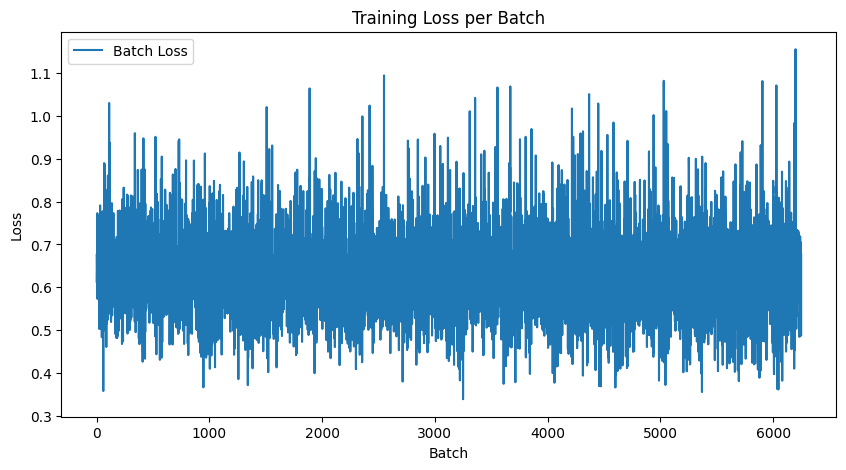

In [104]:
import matplotlib.pyplot as plt

# 학습 루프 전: loss 기록용 리스트
all_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]")

    for batch_idx, batch in enumerate(pbar):
        for k in batch:
            batch[k] = batch[k].to(DEVICE)

        optimizer.zero_grad()

        outputs = model(batch)
        preds = outputs["urgency"]
        targets = batch["urgency"].view(-1).float()

        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        all_losses.append(loss.item())  # <--- batch 단위 loss 기록

        pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] Average Loss: {avg_loss:.4f}")

# --- 학습 완료 후 차트 그리기 ---
plt.figure(figsize=(10,5))
plt.plot(all_losses, label="Batch Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss per Batch")
plt.legend()
plt.show()


##Sentiment

In [74]:
import torch
import torch.nn as nn
from torch.optim import Adam

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Model
model = FusionModel(
    urgency_levels=3,      # 있어도 무방 (출력 안 씀)
    sentiment_levels=4,
    fusion_dim=256,
    dropout=0.2
).to(DEVICE)

# ✅ sentiment 단일 태스크 loss
criterion = nn.CrossEntropyLoss()

optimizer = Adam(
    model.parameters(),
    lr=LEARNING_RATE
)

# (선택) gradient monitor
grad_monitor = GradientMonitor(model)

In [75]:
from tqdm import tqdm
import torch

model.train()

for epoch in tqdm(range(EPOCHS)):
    for batch_idx, batch in enumerate(train_loader):

        for k in batch:
            batch[k] = batch[k].to(DEVICE)

        optimizer.zero_grad()

        outputs = model(batch)
        preds = outputs["sentiment"]          # ✅ 여기

        targets = batch["sentiment"].view(-1).long()  # ✅ 여기 (CE loss)

        loss = criterion(preds, targets)

        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print(
                f"Epoch [{epoch+1}/{EPOCHS}] "
                f"Batch {batch_idx} "
                f"Sentiment Loss: {loss.item():.4f}"
            )


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/2] Batch 0 Sentiment Loss: 1.4702
Epoch [1/2] Batch 50 Sentiment Loss: 0.9888
Epoch [1/2] Batch 100 Sentiment Loss: 1.0862
Epoch [1/2] Batch 150 Sentiment Loss: 1.2710
Epoch [1/2] Batch 200 Sentiment Loss: 1.1706
Epoch [1/2] Batch 250 Sentiment Loss: 1.2493
Epoch [1/2] Batch 300 Sentiment Loss: 0.7201
Epoch [1/2] Batch 350 Sentiment Loss: 0.9428
Epoch [1/2] Batch 400 Sentiment Loss: 0.8812
Epoch [1/2] Batch 450 Sentiment Loss: 1.0012
Epoch [1/2] Batch 500 Sentiment Loss: 0.7401
Epoch [1/2] Batch 550 Sentiment Loss: 1.3647
Epoch [1/2] Batch 600 Sentiment Loss: 0.9856
Epoch [1/2] Batch 650 Sentiment Loss: 0.9080
Epoch [1/2] Batch 700 Sentiment Loss: 0.9113
Epoch [1/2] Batch 750 Sentiment Loss: 0.7758
Epoch [1/2] Batch 800 Sentiment Loss: 1.2215
Epoch [1/2] Batch 850 Sentiment Loss: 0.7555
Epoch [1/2] Batch 900 Sentiment Loss: 0.7495
Epoch [1/2] Batch 950 Sentiment Loss: 0.9113
Epoch [1/2] Batch 1000 Sentiment Loss: 0.9744
Epoch [1/2] Batch 1050 Sentiment Loss: 0.6389
Epoch [1/2]

 50%|█████     | 1/2 [00:02<00:02,  2.09s/it]

Epoch [1/2] Batch 1200 Sentiment Loss: 1.1674
Epoch [2/2] Batch 0 Sentiment Loss: 0.8437
Epoch [2/2] Batch 50 Sentiment Loss: 0.9423
Epoch [2/2] Batch 100 Sentiment Loss: 0.9896
Epoch [2/2] Batch 150 Sentiment Loss: 1.3869
Epoch [2/2] Batch 200 Sentiment Loss: 1.0077
Epoch [2/2] Batch 250 Sentiment Loss: 1.1636
Epoch [2/2] Batch 300 Sentiment Loss: 0.8861
Epoch [2/2] Batch 350 Sentiment Loss: 0.8613
Epoch [2/2] Batch 400 Sentiment Loss: 0.8346
Epoch [2/2] Batch 450 Sentiment Loss: 0.8200
Epoch [2/2] Batch 500 Sentiment Loss: 0.9217
Epoch [2/2] Batch 550 Sentiment Loss: 0.6348
Epoch [2/2] Batch 600 Sentiment Loss: 1.1322
Epoch [2/2] Batch 650 Sentiment Loss: 1.3418
Epoch [2/2] Batch 700 Sentiment Loss: 0.6125
Epoch [2/2] Batch 750 Sentiment Loss: 0.5911
Epoch [2/2] Batch 800 Sentiment Loss: 0.6892
Epoch [2/2] Batch 850 Sentiment Loss: 0.9294
Epoch [2/2] Batch 900 Sentiment Loss: 0.9614
Epoch [2/2] Batch 950 Sentiment Loss: 0.8860
Epoch [2/2] Batch 1000 Sentiment Loss: 0.9890
Epoch [2/2]

100%|██████████| 2/2 [00:04<00:00,  2.13s/it]

Epoch [2/2] Batch 1150 Sentiment Loss: 1.1168
Epoch [2/2] Batch 1200 Sentiment Loss: 0.6757


In [44]:
for epoch in tqdm(range(EPOCHS)):
    model.train()
    for batch_idx, batch in enumerate(train_loader):
        # batch GPU로 이동
        for k in batch:
            batch[k] = batch[k].to(DEVICE)

        optimizer.zero_grad()

        # forward
        outputs = model(batch)
        outputs = {
            "urgency": outputs["urgency"],
            "sentiment": outputs["sentiment"],
        }

        # targets reshape
        targets = {
            "urgency": batch["urgency"].view(-1).float(),
            "sentiment": batch["sentiment"].view(-1).long()
        }

        # loss 계산
        losses = criterion(outputs, targets, epoch)
        # print(losses)
        losses["total"].backward()

        optimizer.step()

        grad_stats = grad_monitor.log(
            {
                "urgency": losses["urgency"].detach(),
                "sentiment": losses["sentiment"].detach(),
            },
            step=batch_idx,
            epoch=epoch,
        )

        if batch_idx % 100 == 0:
            print(grad_stats)

        if batch_idx % 50 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Batch {batch_idx}, Loss: {losses["total"].item():.4f}")


  0%|          | 0/2 [00:00<?, ?it/s]


IndexError: tuple index out of range

In [ ]:
# Model Save

MODEL_DIR = Path("/content/drive/MyDrive/LikeLion/실전 프로젝트 1/Project/models")

# fusion layer
torch.save(
    model.fusion.state_dict(),
    "fusion_linear.pt"
)

# urgency head
torch.save(
    model.urgency_head.state_dict(),
    "urgency_head.pt"
)

# sentiment head
torch.save(
    model.sentiment_head.state_dict(),
    "sentiment_head.pt"
)


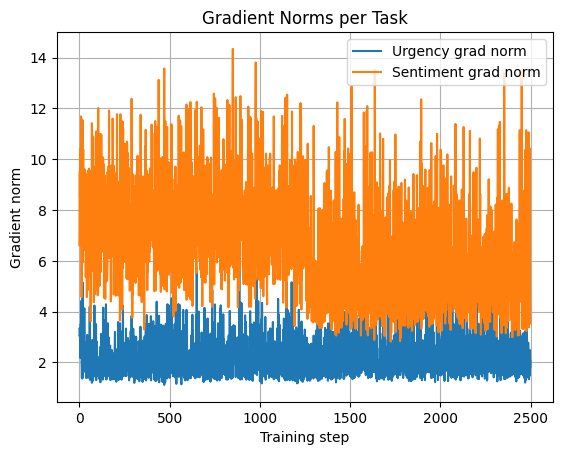

In [63]:
import pandas as pd

df = pd.DataFrame(grad_monitor.history)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(df["urgency_grad_norm"], label="Urgency grad norm")
plt.plot(df["sentiment_grad_norm"], label="Sentiment grad norm")
plt.xlabel("Training step")
plt.ylabel("Gradient norm")
plt.title("Gradient Norms per Task")
plt.legend()
plt.grid(True)
plt.show()